In [1]:
from cts import *
from strategies import *
from settings import *
from utils import *
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, trange
from scipy.io import mmread
import networkx as nx

In [2]:
import sys
# ignore warning for better readibility
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
# plot options
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

# Linear Reward for $m$ sets
In this example, the reward is the sum of all pulled arms and the set of actions is all the subset of arms of size $m$.

In [4]:
ninstances = 50# number of simulations to run
horizon = 1000 # length of each simulation
n = 10 # number of arms

In [5]:
m = 3 # size of each action
means = np.random.uniform(size=n) # we choose means randomly for now
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0

In [6]:
print("Mean vector: ", means)
print("Covariance matrix: ")
print(cov)

Mean vector:  [0.38515531 0.7372562  0.30518005 0.83371649 0.47707447 0.74800651
 0.30608492 0.0163892  0.11124498 0.27582732]
Covariance matrix: 
[[1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1. ]]


In [7]:
# define the mab instance, the reward function, the oracle and the algo
mab = GaussianCombMAB(means, cov)
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algo = clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)

### Some examples on how these classes work.

In [8]:
print('Best action: ', oracle.action(mab.means))
print('Best possible mean reward: ', rew.reward(mab.means, oracle.action(mab.means)))

Best action:  [1 3 5]
Best possible mean reward:  2.318979199000955


In [9]:
print('Algo subgaussian matrix:')
print(np.diag(algo.subg_var))

Algo subgaussian matrix:
[[1.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.2 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.2 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.2 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.2]]


### Simulation

In [10]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = 20 # number of arms
m = 4 # size of each action
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algos = [CUCB(n, oracle=oracle), 
         clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)] 

In [11]:
regret = {}
for algo in algos:
    try: # load saved progress if it exists
        regret[algo.name] = np.load('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name)).tolist()
    except FileNotFoundError:
        regret[algo.name] = []

In [14]:
try:
    np.load('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.random.uniform(size=n)
    np.save('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid), means)
         
try:
    for algo in algos:
        if ninstances>len(regret[algo.name]):
            for _ in trange(ninstances-len(regret[algo.name]), desc='Simulating for algo={}'.format(algo.name), leave=True):
                # generate new instance
                mab = GaussianCombMAB(means, cov)
                algo.reset() # reinitialize the algo
                # simulate instance
                reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
                regret[algo.name].append(reg)
            # save the simulations
            np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    print("Simulations uncomplete. Saved current progress.")

### Plot the mean regret

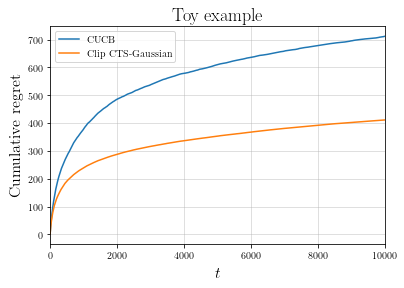

In [15]:
plt.figure()
for algo in algos:
    plt.plot(np.mean(regret[algo.name], axis=0), label=algo.name)
plt.title('Toy example', fontsize=18)
plt.ylabel('Cumulative regret', fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.grid(alpha=0.5)
plt.xlim(0, horizon)
plt.legend()
plt.savefig('figures/linearfixedsize/regret_{}_{}_{}_{}_{}.pgf'.format(n, horizon, m, c, expid))
plt.show()

Here we took almost independent signals so this result is far from surprising.

# Shortest Path Problem

### Generate graph/MAB instance

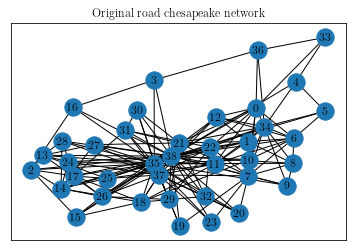

In [4]:
graph = mmread('dataset/road-chesapeake.mtx')
graph = nx.from_scipy_sparse_matrix(graph)
nx.draw_networkx(graph)
plt.title('Original road chesapeake network')
plt.show()

We won't use all the edges of the graph, but only the useful ones to link the source (1) to the target (33).

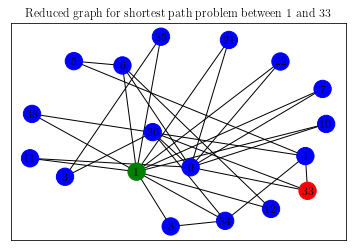

In [5]:
source = 1
target = 33
graph = potential_paths_from_source_to_target(graph, source, target)
# different colors for source and target
color_map = []
for node in graph.nodes:
    if node==source:
        color_map.append('green')
    elif node==target:
        color_map.append('red')
    else:
        color_map.append('blue')
layout = nx.spring_layout(graph, dim=2, k=20, pos={source: [-3, -3], target: [5, 1]})
nx.draw_networkx(graph, node_color=color_map, pos=layout)
plt.title('Reduced graph for shortest path problem between {} and {}'.format(source, target))
plt.show()

### Simulations for independent case

In [6]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = len(graph.edges)
sums = [5, 10, 15, 20] # fixed sum of expected rewards
expid = 0

rew = PathReward(graph)
oracle = ShortestPathOracle(graph)
algos = [CUCB(n, oracle=oracle, sigma=1/2, delta=lambda t:max(1, np.log(t))), 
         CUCBKLPath(n, oracle=oracle, precision=1e-3, max_iter=1000, delta=lambda t:max(1, np.log(t))),
         CTSBetaPath(n, oracle=oracle),
         CTSBetaPath(n, oracle=oracle, optimistic=False)] 

In [7]:
regret = {}
for s in sums:
    for algo in algos:
        try: # load saved progress if it exists
            regret[algo.name, s] = np.load('simulations/shortestpath/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name)).tolist()
        except FileNotFoundError:
            regret[algo.name, s] = []

In [8]:
try:
    means = np.load('simulations/shortestpath/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    #means = np.clip(np.random.normal(1/2, 1/4, size=n), 0, 1)
    means = np.random.uniform(0, 1, size=n)
    np.save('simulations/shortestpath/means_{}_{}.npy'.format(n, expid), means)
       
for i, (u,v) in enumerate(graph.edges): # generate random weights on edges
    graph[u][v]['weight'] = means[i]

try:
    for s in sums:
        mab = BinaryExpSumMAB(means, s=s)

        for algo in algos:
            if ninstances>len(regret[algo.name, s]):
                for _ in trange(ninstances-len(regret[algo.name, s]), desc='Simulating for algo {} and s={}'.format(algo.name, s), leave=True):
                    # generate new instance
                    algo.reset() # reinitialize the algo
                    # simulate instance
                    reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
                    regret[algo.name, s].append(reg)
                # save the simulations
                np.save('simulations/shortestpath/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name), regret[algo.name, s])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/shortestpath/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name), regret[algo.name, s])
    print("Simulations uncomplete. Saved current progress.")

### Visualisation

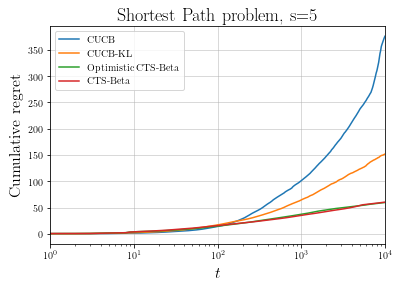

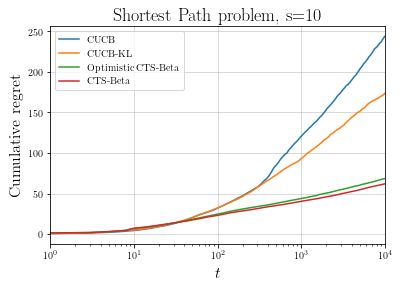

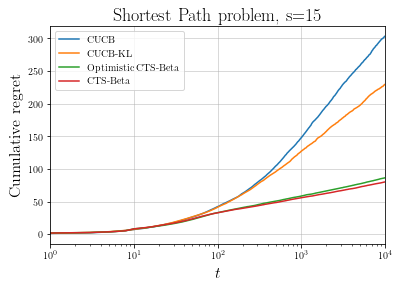

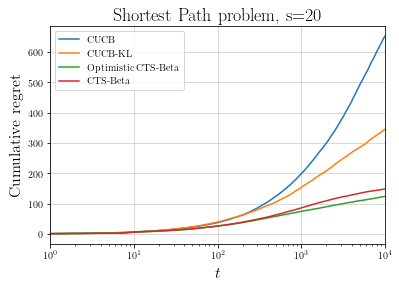

In [9]:
for s in sums:
    plt.figure()
    plt.xscale('log')
    for algo in algos:
        deviation = 3*np.std(regret[algo.name, s], axis=0)/np.sqrt(ninstances)
        mean_regret = np.mean(regret[algo.name, s], axis=0)
        plt.plot(mean_regret, label=algo.name)
        #plt.fill_between(x=np.arange(0,horizon), y1=mean_regret-deviation, y2=mean_regret+deviation, alpha=0.2)
    plt.title('Shortest Path problem, s={}'.format(s), fontsize=18)
    plt.ylabel('Cumulative regret', fontsize=16)
    plt.xlabel('$t$', fontsize=16)
    plt.legend()
    plt.grid(alpha=0.6)
    plt.xlim(0, horizon)
    plt.savefig('figures/shortestpath/regret_{}_{}_{}_{}.pgf'.format(n, horizon, s, expid))
    plt.show()

### Simulations with correlation

In [10]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = len(graph.edges)
sums = [5, 10, 15, 20] # fixed sum of rewards
expid = 0

rew = PathReward(graph)
oracle = ShortestPathOracle(graph)
algos = [CUCB(n, oracle=oracle, sigma=1/2, delta=lambda t:max(1, np.log(t))), 
         CUCBKLPath(n, oracle=oracle, precision=1e-3, max_iter=1000, delta=lambda t:max(1, np.log(t))),
         clipCTSGaussianPath(np.zeros(n), cov=1/4*np.eye(n), oracle=oracle, delta=lambda t:max(1, np.log(t)))] 

In [11]:
regret = {}
for s in sums:
    for algo in algos:
        try: # load saved progress if it exists
            regret[algo.name, s] = np.load('simulations/shortestpath_corr/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name)).tolist()
        except FileNotFoundError:
            regret[algo.name, s] = []

In [12]:
try:
    means = np.load('simulations/shortestpath_corr/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    #means = np.clip(np.random.normal(1/2, 1/4, size=n), 0, 1)
    means = np.random.uniform(0, 1, size=n)
    np.save('simulations/shortestpath_corr/means_{}_{}.npy'.format(n, expid), means)
       
for i, (u,v) in enumerate(graph.edges): # generate random weights on edges
    graph[u][v]['weight'] = means[i]

try:
    for s in sums:
        mab = BinaryCondSumMAB(means, s=s)
        for algo in algos:
            if ninstances>len(regret[algo.name, s]):
                for _ in trange(ninstances-len(regret[algo.name, s]), desc='Simulating for algo {} and s={}'.format(algo.name, s), leave=True):
                    # generate new instance
                    algo.reset() # reinitialize the algo
                    # simulate instance
                    reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
                    regret[algo.name, s].append(reg)
                # save the simulations
                np.save('simulations/shortestpath_corr/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name), regret[algo.name, s])

except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/shortestpath_corr/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, s, expid, algo.name), regret[algo.name, s])
    print("Simulations uncomplete. Saved current progress.")

### Visualisation

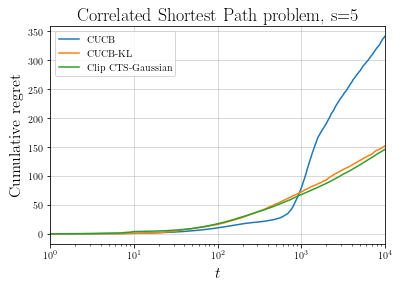

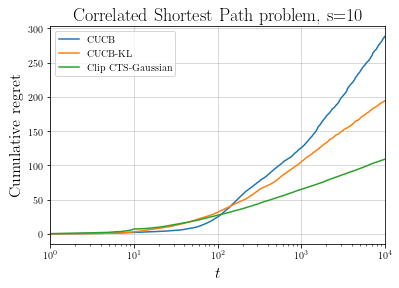

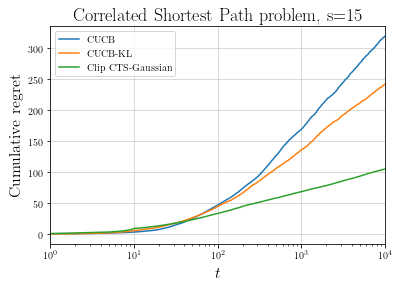

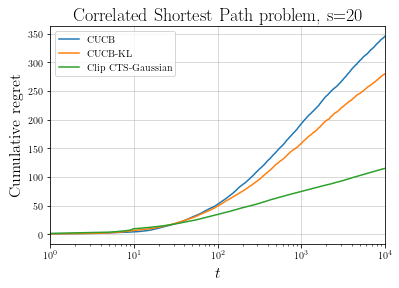

In [14]:
for s in sums:
    plt.figure()
    plt.xscale('log')
    for algo in algos:
        deviation = 3*np.std(regret[algo.name, s], axis=0)/np.sqrt(ninstances)
        mean_regret = np.mean(regret[algo.name, s], axis=0)
        plt.plot(mean_regret, label=algo.name)
        #plt.fill_between(x=np.arange(0,horizon), y1=mean_regret-deviation, y2=mean_regret+deviation, alpha=0.2)
    plt.title('Correlated Shortest Path problem, s={}'.format(s), fontsize=18)
    plt.ylabel('Cumulative regret', fontsize=16)
    plt.xlabel('$t$', fontsize=16)
    plt.legend()
    plt.grid(alpha=0.6)
    plt.xlim(0, horizon)
    plt.savefig('figures/shortestpath_corr/regret_{}_{}_{}_{}.pgf'.format(n, horizon, s, expid))
    plt.show()

# Maximum matching problem

### Generate instance

We here consider a complete bipartite graph (5,5).

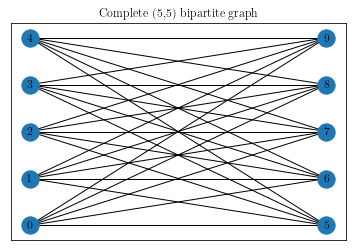

In [15]:
graph = nx.complete_bipartite_graph(5, 5)
left, right = nx.bipartite.sets(graph)
nx.draw_networkx(graph, pos = nx.drawing.layout.bipartite_layout(graph, left))
plt.title('Complete (5,5) bipartite graph')
plt.show()

### Simulations

In [16]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = len(graph.edges)
m = np.minimum(len(left), len(right))
expid = 1
correls = [-1/n, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # term to tune our choice of covariance

rew = MatchingReward(graph)
oracle = MaxMatchingOracle(graph)
algos={}
for c in correls:
    cov = (1-c)*np.eye(n) + c*np.ones((n,n))
    algos[c] = [CUCB(n, oracle=oracle, sigma=1, delta=lambda t:max(1, np.log(t))),
             ESCBCompleteMatching(graph, cov=np.maximum(cov, 0), delta=lambda t:max(1, np.log(t))),
             clipCTSGaussian(np.zeros(n), cov=(1+(m-1)*np.maximum(c,0))*np.eye(n), oracle=oracle, delta=lambda t:max(1, np.log(t)))] 

In [17]:
regret = {}
for c in correls:
    for algo in algos[c]:
        try: # load saved progress if it exists
            regret[algo.name, c] = np.load('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name)).tolist()
        except FileNotFoundError:
            regret[algo.name, c] = []

In [18]:
try:
    means = np.load('simulations/maxmatching/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.random.uniform(0, 1, size=n)
    np.save('simulations/maxmatching/means_{}_{}.npy'.format(n, expid), means)
       
for i, (u,v) in enumerate(graph.edges): # generate random weights on edges
    graph[u][v]['weight'] = means[i]
    
try:  
    for c in correls:
        cov = (1-c)*np.eye(n) + c*np.ones((n,n))
        mab = GaussianCombMAB(means, cov)
        for algo in algos[c]:
            if ninstances>len(regret[algo.name, c]):
                for _ in trange(ninstances-len(regret[algo.name, c]), desc='Simulating for algo {}, c={}'.format(algo.name, c), leave=True):
                    # generate new instance
                    algo.reset() # reinitialize the algo
                    # simulate instance
                    reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
                    regret[algo.name, c].append(reg)
                # save the simulations
                np.save('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name), regret[algo.name, c])

except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name), regret[algo.name, c])
    print("Simulations uncomplete. Saved current progress.")

### Visualisation

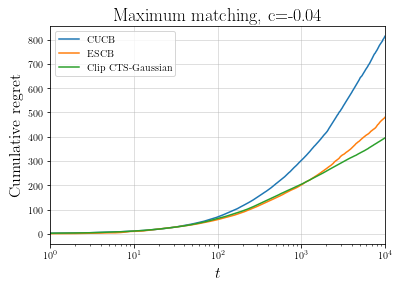

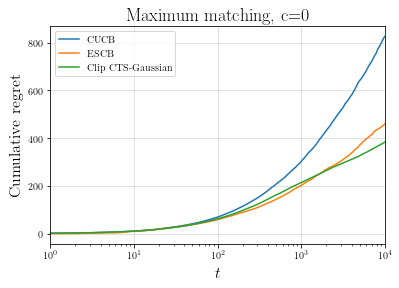

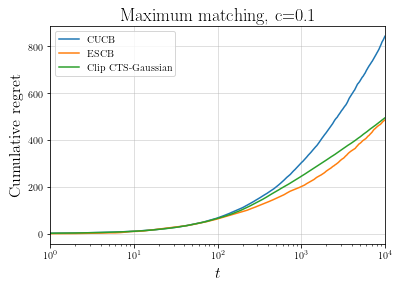

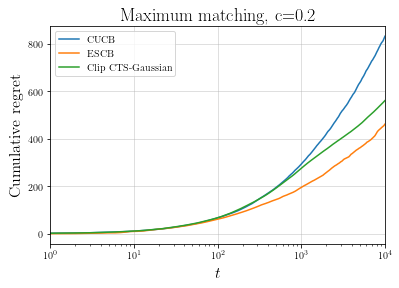

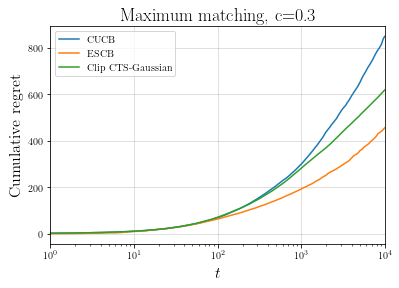

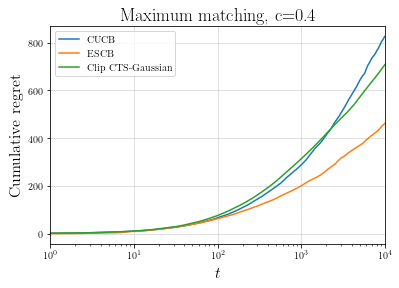

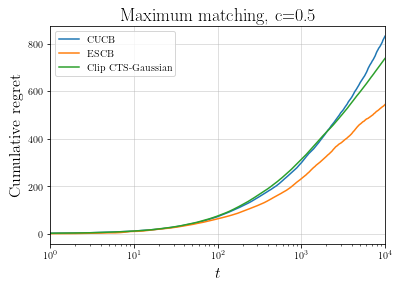

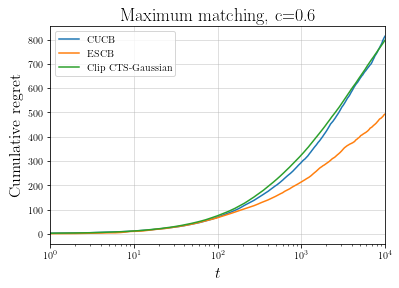

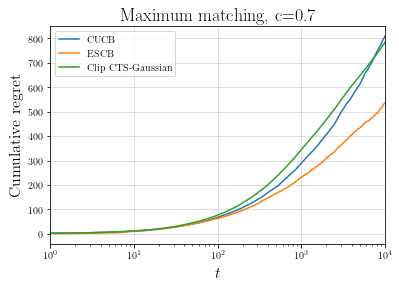

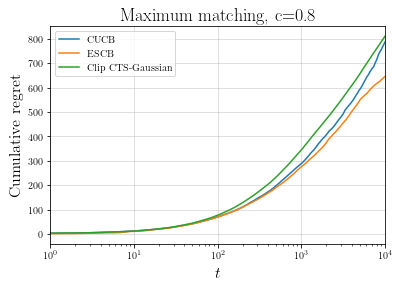

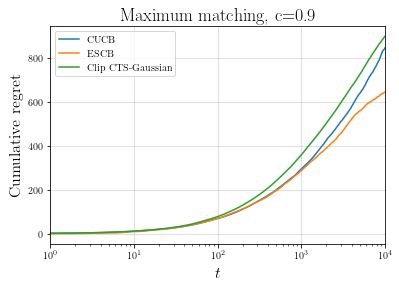

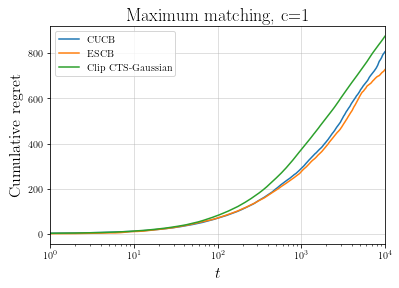

In [19]:
for c in correls:
    plt.figure()
    plt.xscale('log')
    for algo in algos[c]:
        deviation = 3*np.std(regret[algo.name, c], axis=0)/np.sqrt(ninstances)
        mean_regret = np.mean(regret[algo.name, c], axis=0)
        plt.plot(mean_regret, label=algo.name)
        #plt.fill_between(x=np.arange(0,horizon), y1=mean_regret-deviation, y2=mean_regret+deviation, alpha=0.2)
    plt.title('Maximum matching, c={}'.format(c), fontsize=18)
    plt.ylabel('Cumulative regret', fontsize=16)
    plt.xlabel('$t$', fontsize=16)
    plt.grid(alpha=0.5)
    plt.xlim(0, horizon)
    plt.legend()
    plt.savefig('figures/maxmatching/regret_{}_{}_{}_{}.pgf'.format(n, horizon, c, expid))
    plt.show()